This file contains python code to compare with sinica paper

It is under the linear setting

Now, I use the same X and beta from the paper (on Sep 4, 2023)

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd, gen_simu_ts
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn, gen_sini_Xthetas
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from hdf_utils.utils import gen_lam_seq
from hdf_utils.hypo_test import  MS2idxs, obt_test_stat_simple2
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv, gen_Dmat
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_linear_fn
from optimization.opt import optimization
from penalties.scad_pen import SCAD
from models.linear_model import LinearModel

from joblib import Parallel, delayed

R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate




In [5]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Param and fns

## Params

In [97]:
np.random.seed(0)
paras = edict(def_paras.copy())



# Others
paras.num_rep = 200 
paras.init_noise_sd = -1 # the sd of the noise added to the true value for initial values, if -1, make init 0
paras.SIS_ratio = 0.20 # the ratio to keep with SIS procedure
paras.linear_theta_update="cholesky_inv"
paras.is_center = True

# candidate sets of tuning parameters, only two 
# lambda: penalty term
# N: num of basis
paras.can_Ns = [4, 6, 8, 10, 12]


# generating dataset
paras.n = 100 # num of data obs to be genareted
paras.npts = 100 # num of pts to evaluate X(s)
paras.d = 10 # num of ROIs
paras.q = 1 # num of other covariates
paras.sigma2 = 1 # variance of the error
paras.types_ = ["int"]
paras.srho = 0.3 # corr from sinica

# b-spline
paras.x = np.linspace(0, 1, paras.npts)
paras.basis_mats = []
for N in paras.can_Ns:
    paras.basis_mats.append(
        #torch.tensor(obt_bsp_basis_Rfn_wrapper(paras.x, N, paras.ord)).to(torch.get_default_dtype())
        torch.tensor(obt_bsp_obasis_Rfn(paras.x, N, paras.ord)).to(torch.get_default_dtype())
    )

# True parameters
paras.alp_GT = np.array([0])
# fourier basis
cs = [0.0, 0.0, 0.0] # for sinica paper
paras.fourier_basis = fourier_basis_fn(paras.x)[:, :]
paras.fourier_basis_coefs = ([cs[0]*coef_fn(0.2), cs[1]*coef_fn(0.2), cs[2]*coef_fn(0.2)] + 
                             [np.zeros(50)] * (paras.d-3-1) +
                             [coef_fn(0.2)]
                             )
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T 
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs
print(np.linalg.norm(paras.beta_GT, axis=0))

paras.Gam_GT_ests = [(np.linalg.inv(basis_mat.numpy().T 
                                  @ basis_mat.numpy()) 
                                  @ basis_mat.numpy().T 
                                  @ paras.beta_GT) 
                     for basis_mat in paras.basis_mats]
print(np.linalg.norm(paras.Gam_GT_ests[0], axis=0))

paras.num_cv_fold = 5


# hypothesis test
#without loss of generality, we assume the idxs in M is the first m betas
paras.sel_idx = np.arange(1, paras.d) # M^c set, 
paras.M_idxs = np.delete(np.arange(paras.d), paras.sel_idx) # the M set
paras.Cmats = [
    np.eye(len(paras.M_idxs)), # m x m I matrix, [beta1, beta2] = [0, 0]
]
paras.svdinv_eps_Q = 1e-6 # now 0 means inverse, small value like 0.01 means remove small eig vals.
paras.svdinv_eps_Psi = 1e-6

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         14.87358566]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.08287322]


In [67]:
paras.save_dir = RES_ROOT/"simu_linear_sinica_samebetaX_tmp"
if not paras.save_dir.exists():
    paras.save_dir.mkdir()

## Fns

In [8]:
def _gen_simu_data_all(seed, paras, verbose=False):
    """
    Generate simulated data for all parameters.

    Args:
        seed (int): Seed for random number generator.
        paras (dict): Dictionary containing the following parameters:
            - srho: corr from sinica
            - fourier_basis: The fourier basis for generating X, npts x nbasis
            - n (int): Number of samples.
            - d (int): Number of dimensions.
            - q (int): Number of covariates.
            - types_ (list): List of types for generating covariates.
            - alp_GT (list): List of ground truth alpha values.
            - beta_GT (list): List of ground truth beta values.
            - freqs (list): List of frequencies for generating simulated PSD.
            - sigma2 (float): Variance of the noise.
        verbose(bool): Verbose or not

    Returns:
        all_data (dict): Dictionary containing the following simulated data:
            - X (torch.Tensor): Tensor of shape (n, d, npts) containing the simulated PSD.
            - Y (torch.Tensor): Tensor of shape (n,) containing the response variable.
            - Z (torch.Tensor): Tensor of shape (n, q) containing the covariates.
    """
    torch.set_default_tensor_type(torch.DoubleTensor)
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
   
    thetas = gen_sini_Xthetas(_paras.srho, _paras.n, _paras.d);
    simu_curvs = thetas @ _paras.fourier_basis.T; # n x d x npts
    #simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts)*10
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_curvs[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    
    # Y 
    errs_raw = np.random.lognormal(0, 1, _paras.n)
    errs = np.sqrt(_paras.sigma2)*(errs_raw - errs_raw.mean())/errs_raw.std()  
    errs = np.sqrt(_paras.sigma2)*np.random.randn(_paras.n)
    Y = lin_term + errs
    
    Y_centered = Y - Y.mean(axis=0, keepdims=True)
    X_centered = simu_curvs - simu_curvs.mean(axis=0, keepdims=True)
    
    # To torch
    X = torch.Tensor(X_centered) # n x d x npts
    Z = torch.Tensor(simu_covs) # n x q
    Y = torch.Tensor(Y_centered)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    all_data.errs = errs
    return all_data

# Simu

## Simulation

In [77]:
# this file contains fns for CV
from hdf_utils.likelihood import obt_lin_tm


def CV_err_linear_fn_nopen(data, num_cv_fold, input_paras={}):
    
    # default parameter
    _paras = {
        "sigma2": 1,
        "basis_mat": None,
        'is_center': True}
    _paras = edict(_paras)
    _paras.update(input_paras)
    
    _paras.n = data.Y.shape[0]
    
    # initial value
    
    num_test = int(_paras.n/num_cv_fold)
    full_idx = np.arange(_paras.n)
    test_Y_err_all = []
    for ix in range(num_cv_fold):
        test_idx = full_idx[(ix*num_test):(ix*num_test+num_test)]
        if ix == num_cv_fold-1:
            test_idx = full_idx[(ix*num_test):] # including all remaining data
        train_idx = np.delete(full_idx, test_idx)
        
        test_set_X = data.X[test_idx]
        test_set_Y = data.Y[test_idx]
        test_set_Z = data.Z[test_idx]
        
        train_set_X = data.X[train_idx]
        train_set_Y = data.Y[train_idx]
        train_set_Z = data.Z[train_idx]
        
        if _paras.is_center:
            test_set_X = test_set_X - train_set_X.mean(axis=0, keepdims=True)
            test_set_Y = test_set_Y - train_set_Y.mean(axis=0, keepdims=True)
            # Now, I do not have time to write code to center Z
            # It is a bit tedious, you should exclude intercept and categorical var
            #test_set_Z = test_set_Z - train_set_Z.mean(axis=0, keepdims=True)
            
            train_set_X = train_set_X - train_set_X.mean(axis=0, keepdims=True)
            train_set_Y = train_set_Y - train_set_Y.mean(axis=0, keepdims=True)
            #train_set_Z = train_set_Z - train_set_Z.mean(axis=0, keepdims=True)
        
        cur_model = LinearModel(Y=train_set_Y, X=train_set_X, Z=train_set_Z, 
                        basis_mat=_paras.basis_mat, 
                        sigma2=_paras.sigma2)
        cur_model._linear_term_der();
        right_vec = (cur_model.Y.unsqueeze(-1)*cur_model.lin_tm_der).mean(dim=0)
        left_mat = cur_model.lin_tm_der.T@cur_model.lin_tm_der/len(cur_model.Y)
        #left_mat_inv = torch.linalg.pinv(left_mat, hermitian=True, rtol=1e-2)
        left_mat_inv = svd_inverse(left_mat, 0.999)
        est_theta = left_mat_inv @ right_vec;
        est_alp = est_theta[:_paras.q]
        est_Gam = col_vec2mat_fn(est_theta[_paras.q:], _paras.N) * np.sqrt(_paras.N);
        
        test_Y_est = obt_lin_tm(test_set_Z, test_set_X, est_alp, est_Gam, _paras.basis_mat)
        test_Y_err = test_set_Y - test_Y_est
        test_Y_err_all.append(test_Y_err.numpy())
    test_Y_err_all = np.concatenate(test_Y_err_all)
    return test_Y_err_all

In [78]:
def get_Amat(k, Cmat, paras):
    """Get A matrix for hypothesis test
        k: Num of elements in S
        Cmat: Hypothesis matrix
        paras: parameters
                required: N, m, q
    """
    _paras = edict(paras.copy())
    
    m = Cmat.shape[-1]
    part1 = np.kron(Cmat, np.eye(_paras.N))
    part2 = np.zeros((m*_paras.N, _paras.q+(m+k)*_paras.N))
    part2[:, _paras.q:(_paras.q+m*_paras.N)] = np.eye(m*_paras.N)
    A = part1 @ part2
    return A

def obt_test_stat_nopen(Q_mat, Sig_mat, est_alp, est_Gam, Cmat, paras):
    
    _paras = edict(paras.copy())
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    
    # A mat
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    Amat = torch.Tensor(get_Amat(k, Cmat, _paras))
    
    # calculate Test stats
    #Q_mat_part_inv = torch.linalg.pinv(Q_mat)
    Q_mat_part_inv = svd_inverse(Q_mat, 0.999)
    #Q_mat_part_inv = torch.linalg.pinv(Q_mat, hermitian=True, rtol=_paras.svdinv_eps_Q)
    #print(Amat.shape, Sig_mat.shape, Q_mat_part_inv.shape)
    Psi = Amat @ Q_mat_part_inv @ Sig_mat @ Q_mat_part_inv @ Amat.T
    #print(torch.linalg.cond(Psi))
    #Psi_inv = torch.linalg.pinv(Psi)
    Psi_inv = svd_inverse(Psi, 0.999)
    #Psi_inv = torch.linalg.pinv(Psi, hermitian=True, rtol=_paras.svdinv_eps_Psi)
    
    T_p1 = Amat @ est_theta
    T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
    T_v = T_v.item()
    pval = chi2.sf(T_v, Cmat.shape[0]*_paras.N)
    return T_v, pval

In [79]:
def _run_fn(seed, N, Cmat, paras, is_cv=False):
    _paras = edict(paras.copy())
    _paras.seed = seed
    _paras.N = N
    _paras.basis_mat = _paras.basis_mats[_paras.can_Ns.index(_paras.N)]
    _paras.Gam_GT_est = paras.Gam_GT_ests[_paras.can_Ns.index(_paras.N)]
    cur_data = _gen_simu_data_all(_paras.seed, _paras);
    
    #oracle_idx_set = [0, 1, _paras.d-1]
    cur_data_oracle = edict(cur_data.copy())
    #cur_data_oracle.X = cur_data.X[:, oracle_idx_set, :]
    
    model = LinearModel(Y=cur_data_oracle.Y, 
                        X=cur_data_oracle.X,
                        Z=cur_data_oracle.Z, 
                        basis_mat=_paras.basis_mat, 
                        sigma2=_paras.sigma2)
    model._linear_term_der();
    #right_vec = (model.Y.unsqueeze(-1)*model.lin_tm_der).mean(dim=0)
    #left_mat = model.lin_tm_der.T@model.lin_tm_der/len(model.Y)
    #left_mat_inv = torch.linalg.pinv(left_mat, hermitian=True, rtol=1e-2)
    #est_theta = left_mat_inv @ right_vec;
    Xt = model.lin_tm_der # Mx(q+dN)
    est_theta = svd_inverse(Xt.T @ Xt,0.999)@Xt.T@model.Y
    #est_theta = torch.linalg.pinv(Xt.T @ Xt, hermitian=True, rtol=1e-2)@Xt.T@model.Y
    est_alp = est_theta[:_paras.q]
    est_Gam = col_vec2mat_fn(est_theta[_paras.q:], _paras.N) * np.sqrt(_paras.N);
    est_beta = _paras.basis_mat @ est_Gam;
    
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0);
    
    test_res = obt_test_stat_nopen(Q_mat, Sig_mat, est_alp, est_Gam, Cmat, _paras);
    
    if is_cv:
        cv_errs = CV_err_linear_fn_nopen(cur_data_oracle, 5, _paras);
    else:
        cv_errs = None
    
    ress = edict()
    ress.test_res = test_res
    ress.cv_errs = cv_errs
    ress.est_alp = est_alp
    ress.est_Gam = est_Gam
    ress.est_beta = est_beta
    ress.N = _paras.N
    ress.seed = _paras.seed
    ress.Q_mat = Q_mat
    return ress

## Test

In [260]:
Cmat = np.eye(1)
N = 10
paras.num_rep = 1000
with Parallel(n_jobs=20) as parallel:
    ress = parallel(delayed(_run_fn)(seed,  N=N, Cmat=Cmat, paras=paras)
                    for seed
                    in tqdm(range(paras.num_rep), total=paras.num_rep))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 119.46it/s]


In [261]:
np.median([torch.linalg.cond(res.Q_mat).mean() for res in ress])

16727899054.068024

In [262]:
pvals = np.array([res.test_res[1] for res in ress])
T_vs = np.array([res.test_res[0] for res in ress]);

In [263]:
np.mean(T_vs), np.mean(pvals<=0.05)

(9.317855350836515, 0.063)

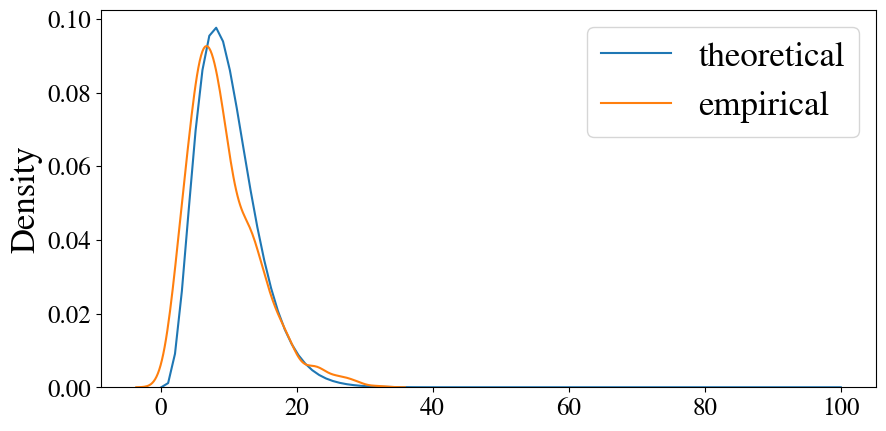

In [264]:
chi_df = Cmat.shape[0]*N
xs = np.linspace(0.1, 100, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(T_vs, label="empirical")
plt.legend()

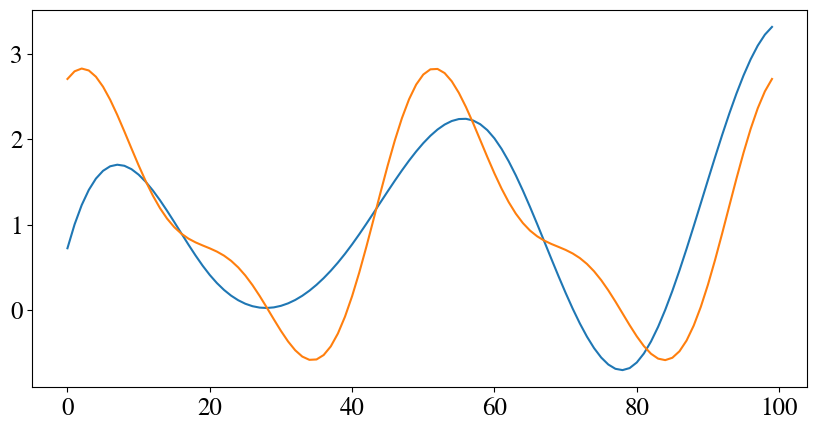

In [254]:
plt.plot(ress[2].est_beta[:, -1])
plt.plot(paras.beta_GT[:, -1])

## N simu

In [98]:
Cmat = np.eye(1)
paras.num_rep = 300
all_coms = itertools.product(range(0, paras.num_rep), paras.can_Ns)
with Parallel(n_jobs=20) as parallel:
    ress = parallel(delayed(_run_fn)(seed,  N=N, Cmat=Cmat, paras=paras, is_cv=True)
                    for seed, N 
                    in tqdm(all_coms, total=len(paras.can_Ns)*paras.num_rep))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 149.03it/s]


In [99]:
all_coms = np.array(list(itertools.product(range(0, paras.num_rep), paras.can_Ns)));

In [100]:
test_ress = edict()
test_ress.pvals = []
test_ress.T_vs = []
test_ress.sel_Ns = []
for seed in range(paras.num_rep):
    low_idx, up_idx = seed * len(paras.can_Ns), (seed+1)*len(paras.can_Ns)
    press = ress[low_idx:up_idx]
    errs = []
    for res in press:
        err = np.mean((res.cv_errs)**2)
        errs.append(err)
    min_idx = np.argmin(errs)
    bres = press[min_idx]
    test_ress.pvals.append(bres.test_res[1])
    test_ress.T_vs.append(bres.test_res[0])
    test_ress.sel_Ns.append(paras.can_Ns[min_idx])

In [101]:
for key in test_ress.keys():
    test_ress[key] = np.array(test_ress[key])
np.mean(np.array(test_ress.pvals) <= 0.05)

0.2633333333333333

In [102]:
N_set = np.unique(test_ress.sel_Ns);
for cur_N in N_set:
    print(test_ress.T_vs[test_ress.sel_Ns==cur_N].mean(), cur_N, np.sum(test_ress.sel_Ns==cur_N))
    

7.158531537879504 4 266
8.67780964267925 6 30
17.599898693288583 8 3
22.70609044560127 10 1


<Axes: ylabel='Density'>

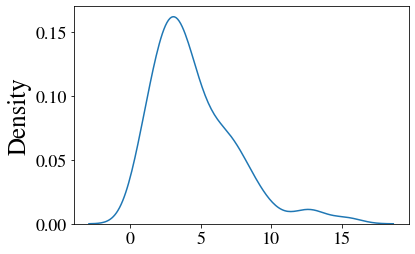

In [74]:
sns.kdeplot(test_ress.T_vs[test_ress.sel_Ns==6])